# Predicting student success with machine learning techniques

Course: Supervised Learning (MS-CS)  
Institution: University of Colorado Boulder  
Dataset: Student Success: Factors & Insights  
Date: 14 October 2025  

## Project overview

In the project, I’m exploring what drives student performance and how well we can predict exam outcomes using standard supervised learning techniques.
The primary goal is to understand how behavioral, demographic, and socioeconomic factors influence scores and whether simple models can help identify students who might need more support early on.

To go one step further, I also include a small extension to explore new behavioral predictors related to AI assisted learning using a global dataset on student perceptions of ChatGPT.

## 1. Problem definition and data sources

### 1.1 Problem statement

The project focuses on predicting student exam performance based on behavioral, demographic, and school related factors.

The primary goal is to see how well supervised learning models can explain and / or predict academic success.

The assumption is that this model could, to some extend, help identify factors to focus on when designing new courses and organizing course work to accomadate better student outcomes.

The task is a regression problem where the target variable is the exam score, and the input features include study habits, attendance, and prior academic performance. Understanding what drives student success helps educators identify which learning behaviors have the strongest impact on outcomes. The analysis compares several regression models to evaluate which best captures these relationships while balancing accuracy and interpretability.

Although this dataset has been analyzed in other public notebooks, this project extends previous work by including additional models such as Gradient Boosting and Polynomial Regression, tuning hyperparameters, and visualizing model performance.

Finally, in the short exploratory extension, the project incorporates a second dataset: a global survey of higher education students’ perceptions of ChatGPT. The goal is to identify behavioral / attitudinal features that could serve as new predictors of learning success. If such variables were added to traditional academic data, they might improve the model’s explanatory power and provide a more current perspective on student learning.

### 1.2 Primary dataset: Student performance factors

Source: https://www.kaggle.com/datasets/anassarfraz13/student-success-factors-and-insights  
Author: Anas Sarfraz (2024)  
License: CC0 Public Domain  
Records: 6,607 rows × 20 columns  
File: StudentPerformanceFactors.csv  

The dataset covers multiple aspects of student life including study habits, attendance, family background, and access to learning resources.
It is a realistic, moderately clean dataset that works well for testing different regression models without much preprocessing effort.

### 1.3 Exploratory dataset: Global student perceptions of ChatGPT

Source: https://www.kaggle.com/datasets/jocelyndumlao/global-student-perceptions-of-chatgpt  
Author: Jocelyn Dumlao (2024)  
License: CC BY-NC 4.0  
Records: 23,218 rows × 174 columns  
File: final dataset.xlsx  

This dataset contains survey responses from higher education students across 109 countries on how they use ChatGPT, for what purposes, and how they perceive its impact on their learning. The data includes questions on usage frequency, confidence, ethical concerns, and perceived academic improvement.
It provides a rich behavioral perspective that complements the main performance dataset and supports exploratory analysis on how AI-assisted learning patterns relate to student outcomes.

### 1.4 Why these datasets

The main dataset is small enough to experiment quickly but broad enough to represent different drivers of academic performance.  
The second dataset adds scale and behavioral context that allow us to explore new predictors of learning outcomes.  
Together they create a compact yet forward looking study: traditional academic success modeling enriched with contemporary factors related to AI-assisted learning.

## 2. Environment setup and data loading

Before jumping into analysis, I’ll load the main libraries for data handling, visualization, and modeling.  
The goal here is to get the basic environment ready and verify that the dataset loads correctly.

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path

# Machine learning libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# General setup
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 10

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("Libraries loaded successfully")
print(f"Random seed set to: {RANDOM_STATE}")

Matplotlib is building the font cache; this may take a moment.


Libraries loaded successfully
Random seed set to: 42


### 2.1 Load dataset

I downloaded the data for the primary study directly from Kaggle and I'm pulling the dataset directly from the local path under `data/raw/`. 

In [12]:
data_path = Path('../data/raw/StudentPerformanceFactors.csv')
df = pd.read_csv(data_path)

print("Dataset loaded successfully")
print(f"Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
df.head()

Dataset loaded successfully
Shape: 6,607 rows × 20 columns


,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender,Exam_Score
0,23,84,Low,High,No,7,73,Low,Yes,0,Low,Medium,Public,Positive,3,No,High School,Near,Male,67
1,19,64,Low,Medium,No,8,59,Low,Yes,2,Medium,Medium,Public,Negative,4,No,College,Moderate,Female,61
2,24,98,Medium,Medium,Yes,7,91,Medium,Yes,2,Medium,Medium,Public,Neutral,4,No,Postgraduate,Near,Male,74
3,29,89,Low,Medium,Yes,8,98,Medium,Yes,1,Medium,Medium,Public,Negative,4,No,High School,Moderate,Male,71
4,19,92,Medium,Medium,Yes,6,65,Medium,Yes,3,Medium,High,Public,Neutral,4,No,College,Near,Female,70


## 3. Exploratory data analysis

The goal of this section is to get familiar with the dataset, how it’s structured, what the columns look like, and whether there are any quality issues we need to fix before training models.

### 3.1 Dataset overview

To understand the basic structure of the data, I’ll look at the columns, data types, and memory usage.

In [14]:
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")
print("\nColumn information:")
print("=" * 70)
df.info()

Rows: 6607, Columns: 20

Column information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6607 entries, 0 to 6606
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Hours_Studied               6607 non-null   int64 
 1   Attendance                  6607 non-null   int64 
 2   Parental_Involvement        6607 non-null   object
 3   Access_to_Resources         6607 non-null   object
 4   Extracurricular_Activities  6607 non-null   object
 5   Sleep_Hours                 6607 non-null   int64 
 6   Previous_Scores             6607 non-null   int64 
 7   Motivation_Level            6607 non-null   object
 8   Internet_Access             6607 non-null   object
 9   Tutoring_Sessions           6607 non-null   int64 
 10  Family_Income               6607 non-null   object
 11  Teacher_Quality             6529 non-null   object
 12  School_Type                 6607 non-null   object
 13  Pee

In [15]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Hours_Studied,6607.0,19.975329,5.990594,1.0,16.0,20.0,24.0,44.0
Attendance,6607.0,79.977448,11.547475,60.0,70.0,80.0,90.0,100.0
Sleep_Hours,6607.0,7.029060,1.468120,4.0,6.0,7.0,8.0,10.0
Previous_Scores,6607.0,75.070531,14.399784,50.0,63.0,75.0,88.0,100.0
Tutoring_Sessions,6607.0,1.493719,1.230570,0.0,1.0,1.0,2.0,8.0
Physical_Activity,6607.0,2.967610,1.031231,0.0,2.0,3.0,4.0,6.0
Exam_Score,6607.0,67.235659,3.890456,55.0,65.0,67.0,69.0,101.0


### 3.3 Check for duplicates or missing values

Before any modeling, I'll check if we’re dealing with repeated records or missing data that could skew results.

In [16]:
duplicates = df.duplicated().sum()
missing = df.isnull().sum().sort_values(ascending=False)

print(f"Duplicate rows: {duplicates}")
print("\nMissing values by column:")
print(missing[missing > 0] if missing.sum() > 0 else "No missing values found")

Duplicate rows: 0

Missing values by column:
Parental_Education_Level    90
Teacher_Quality             78
Distance_from_Home          67
dtype: int64


### 3.4 Data cleaning

Before training, I reviewed the dataset for missing values and data consistency.  
Three categorical features contained missing values: Parental_Education_Level, Teacher_Quality, and Distance_from_Home.  
I'll fill these with the most frequent category because these variables represent discrete choices, and replacing them with a dominant category preserves the distribution without distorting feature relationships.  

No numeric columns had missing values, so no imputation is required.  
After verifying that no NaN values remain, I'll apply hot encoding to transform categorical variables into binary indicator columns and use standard scaling for numeric features.  
This will ensure that all variables are in comparable ranges and suitable for the regression and tree based models that will be trained later.

For the exploratory extension that I'll introduce later, I'll repeat similar validation and cleaning steps to make the additional dataset comparable and ready for considering a potential integration of new predictors of student success through new approaches to learning in the future.

In [17]:
# Fill missing values with mode for categorical columns
for col in ['Parental_Education_Level', 'Teacher_Quality', 'Distance_from_Home']:
    mode_value = df[col].mode()[0]
    df[col].fillna(mode_value, inplace=True)
    print(f"Filled missing values in '{col}' with mode: {mode_value}")

# Verify cleanup
print("\nRemaining missing values:")
print(df.isnull().sum().sum())

Filled missing values in 'Parental_Education_Level' with mode: High School
Filled missing values in 'Teacher_Quality' with mode: Medium
Filled missing values in 'Distance_from_Home' with mode: Near

Remaining missing values:
0


## 4. Data preprocessing

Before training models, I’ll prepare the dataset for ML, meaning encoding categorical variables, scaling numerical features, and splitting the data into training and testing sets. The target variable is Exam_Score, and all other columns will serve as predictors.

In [18]:
# Separate target variable and feature set
target = 'Exam_Score'
X = df.drop(columns=[target])
y = df[target]

print("Feature set shape:", X.shape)
print("Target shape:", y.shape)

Feature set shape: (6607, 19)
Target shape: (6607,)


### 4.1 Encoding categorical variables

Several columns are categorical (for example gender, motivation, or family income). I’ll use hot encoding to convert them into numeric format suitable for regression models.

In [ ]:
# Identify categorical columns
categorical_cols = X.select_dtypes(include='object').columns
print("Categorical columns:", list(categorical_cols))

# Apply hot encoding
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

print("Encoded feature set shape:", X_encoded.shape)
X_encoded.head()

Categorical columns: ['Parental_Involvement', 'Access_to_Resources', 'Extracurricular_Activities', 'Motivation_Level', 'Internet_Access', 'Family_Income', 'Teacher_Quality', 'School_Type', 'Peer_Influence', 'Learning_Disabilities', 'Parental_Education_Level', 'Distance_from_Home', 'Gender']
Encoded feature set shape: (6607, 27)


,Hours_Studied,Attendance,Sleep_Hours,Previous_Scores,Tutoring_Sessions,Physical_Activity,Parental_Involvement_Low,Parental_Involvement_Medium,Access_to_Resources_Low,Access_to_Resources_Medium,...,Teacher_Quality_Medium,School_Type_Public,Peer_Influence_Neutral,Peer_Influence_Positive,Learning_Disabilities_Yes,Parental_Education_Level_High School,Parental_Education_Level_Postgraduate,Distance_from_Home_Moderate,Distance_from_Home_Near,Gender_Male
0,23,84,7,73,0,3,True,False,False,False,...,True,True,False,True,False,True,False,False,True,True
1,19,64,8,59,2,4,True,False,False,True,...,True,True,False,False,False,False,False,True,False,False
2,24,98,7,91,2,4,False,True,False,True,...,True,True,True,False,False,False,True,False,True,True
3,29,89,8,98,1,4,True,False,False,True,...,True,True,False,False,False,True,False,True,False,True
4,19,92,6,65,3,4,False,True,False,True,...,False,True,True,False,False,False,False,False,True,False


### 4.2 Feature scaling and train / test split

After encoding, I’ll scale the numeric features so that models relying on distance or gradient based methods perform better. Then I’ll split the data into training and test sets to evaluate model performance on unseen data.

In [42]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

# Scale numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Feature scaling completed")

Training set shape: (5285, 27)
Test set shape: (1322, 27)
Feature scaling completed


## 5. Model training and evaluation

With the data prepared, I’ll start by training a simple baseline model using linear regression to create a baseline to compare against more complex models later.

In [51]:
# Train baseline model
baseline_model = LinearRegression()
baseline_model.fit(X_train_scaled, y_train)

# Predict on training and test sets
y_train_pred = baseline_model.predict(X_train_scaled)
y_test_pred = baseline_model.predict(X_test_scaled)

# Evaluate performance
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

print("Baseline model: Linear Regression")
print(f"Train RMSE: {train_rmse:.3f}")
print(f"Test RMSE: {test_rmse:.3f}")
print(f"Train r2: {train_r2:.3f}")
print(f"Test r2: {test_r2:.3f}")
print(f"Train MAE: {train_mae:.3f}")
print(f"Test MAE: {test_mae:.3f}")

Baseline model: Linear Regression
Train RMSE: 2.085
Test RMSE: 1.804
Train r2: 0.717
Test r2: 0.770
Train MAE: 0.498
Test MAE: 0.452


### 5.1 Baseline interpretation

The baseline Linear Regression model performed strongly, with an r2 of 0.77 and a low RMSE of 1.80 on the test set. This suggests that most of the variance in student exam performance can be explained through linear relationships between factors such as study time, attendance, and prior achievement. The small gap between training and test scores indicates that the model generalizes well and does not show major signs of overfitting.

Even though this baseline performs well, it assumes strictly linear and additive effects among predictors. To confirm whether there are any non linear patterns or interactions, such as the effect of attendance depending on study time, I will next explore more flexible models including Polynomial Regression, Decision Trees, and Ensemble methods. This is simply to ensure that the chosen model captures the underlying structure of the data rather than fitting well by coincidence.

### 5.2 Multiple model comparison

In this section, I’ll now train and compare several supervised learning models to test whether more flexible algorithms improve prediction accuracy.
The goal is to see which model best predicts exam scores on unseen data.
I’ll include both linear and non-linear models to observe how complexity affects performance.

In [50]:
# Define models to compare
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "SVR": SVR(kernel='rbf')
}

results = {}

# Train and evaluate models
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    results[name] = {"RMSE": rmse, "r2": r2, "MAE": mae}
    print(f"{name} -> RMSE: {rmse:.3f}, r2: {r2:.3f}, MAE: {mae:.3f}")

# Convert results
results_df = pd.DataFrame(results).T
results_df

Linear Regression -> RMSE: 1.804, r2: 0.770, MAE: 0.452
Decision Tree -> RMSE: 3.767, r2: -0.004, MAE: 1.894
Random Forest -> RMSE: 2.225, r2: 0.650, MAE: 1.177
Gradient Boosting -> RMSE: 1.950, r2: 0.731, MAE: 0.820
SVR -> RMSE: 1.839, r2: 0.761, MAE: 0.507


,RMSE,r2,MAE
Linear Regression,1.804445,0.769650,0.452392
Decision Tree,3.767446,-0.004144,1.894100
Random Forest,2.225173,0.649709,1.176732
Gradient Boosting,1.950206,0.730932,0.819741
SVR,1.838570,0.760854,0.506750


### 5.3 Basic model comparison results

It's now clear that linear regression performed best overall with the lowest RMSE and highest r2, showing that a simple linear model captures most of the relationships in the data.
SVR came close, suggesting that limited non linear effects exist but do not dominate contrary to my initial assumption. Tree based models like RF and Gradient Boosting underperformed, likely due to the small dataset and lack of complex feature interactions.

### 5.4 Hyperparameter tuning (sense check)

Although linear regression performed best, I'll tune the RF to confirm whether parameter optimization could close the performance gap, and perform a grid search with cross validation tested combinations of depth, estimators, and split criteria.

In [46]:
# Define parameter grid for RF
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [10, 20, None],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2]
}

rf = RandomForestRegressor(random_state=42, n_jobs=-1)

# Grid search with cross validation
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_scaled, y_train)

print("Best parameters found:")
print(grid_search.best_params_)
print(f"Best cross-validation RMSE: {-grid_search.best_score_:.3f}")

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters found:
{'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Best cross-validation RMSE: 2.430


### 5.5 Evaluating the tuned model

Next, I’ll evaluate the tuned RF to compare its generalization performance against the baseline linear regression. 
The goal is to see whether hyperparameter tuning meaningfully reduces test error or closes the performance gap observed during cross validation.

In [49]:
# Evaluate tuned model
best_rf = grid_search.best_estimator_
y_test_pred_tuned = best_rf.predict(X_test_scaled)

rmse_tuned = np.sqrt(mean_squared_error(y_test, y_test_pred_tuned))
r2_tuned = r2_score(y_test, y_test_pred_tuned)
mae_tuned = mean_absolute_error(y_test, y_test_pred_tuned)

print("Tuned Random Forest performance:")
print(f"Test RMSE: {rmse_tuned:.3f}")
print(f"Test r2: {r2_tuned:.3f}")
print(f"Test MAE: {mae_tuned:.3f}")

Tuned Random Forest performance:
Test RMSE: 2.175
Test r2: 0.665
Test MAE: 1.137


### 5.6 Gradient boosting regressor

I’ll now test a Gradient Boosting model for testing an ensemble method. Unlike RF, which averages multiple independent trees, Gradient Boosting builds trees in sequentially so that each new one corrects the errors of the previous model.  
The goal is to see whether this iterative bias correction approach can outperform both the linear regression and the tuned RF on the same dataset.

In [48]:
from sklearn.ensemble import GradientBoostingRegressor

gb_model = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    random_state=42
)
gb_model.fit(X_train_scaled, y_train)
y_pred_gb = gb_model.predict(X_test_scaled)

gb_rmse = np.sqrt(mean_squared_error(y_test, y_pred_gb))
gb_r2 = r2_score(y_test, y_pred_gb)
gb_mae = mean_absolute_error(y_test, y_pred_gb)

print("Gradient boosting performance:")
print(f"Test RMSE: {gb_rmse:.3f}")
print(f"Test r2: {gb_r2:.3f}")
print(f"Test MAE: {gb_mae:.3f}")

Gradient boosting performance:
Test RMSE: 1.905
Test r2: 0.743
Test MAE: 0.691


### 5.7 Polynomial regression

Finally, I’ll test Polynomial Regression as a nonlinear extension of the linear model. It introduces squared and interaction terms between features to capture smooth nonlinear relationships without relying on tree ensembles.  
This might help check whether or not moderate nonlinearity can improve predictive accuracy while maintaining model interpretability.

In [47]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

poly_model = Pipeline([
    ("poly_features", PolynomialFeatures(degree=2, include_bias=False)),
    ("linear_regression", LinearRegression())
])
poly_model.fit(X_train_scaled, y_train)
y_pred_poly = poly_model.predict(X_test_scaled)

poly_rmse = np.sqrt(mean_squared_error(y_test, y_pred_poly))
poly_r2 = r2_score(y_test, y_pred_poly)
poly_mae = mean_absolute_error(y_test, y_pred_poly)

print("Polynomial regression performance:")
print(f"Test RMSE: {poly_rmse:.3f}")
print(f"Test r2: {poly_r2:.3f}")
print(f"Test MAE: {poly_mae:.3f}")

Polynomial regression performance:
Test RMSE: 1.891
Test r2: 0.747
Test MAE: 0.642


Both gradient boosting and polynomial regression slightly improved over the tuned RF, with RMSEs around 1.9 and r2 values near 0.74.  
Gradient boosting performed slightly better than the tree based ensemble, confirming that bias reduction can enhance performance on already structured data.  
Polynomial regression achieved comparable accuracy, suggesting that the data’s underlying relationships remain mostly linear with mild nonlinear effects.  

Because this dataset captures student performance patterns such as study habits, attendance, and prior achievement, it reflects smooth and consistent relationships rather than abrupt or irregular interactions.  
In this context, simpler models like linear regression actually align better with the data’s structure and meaning because they explain variation transparently and generalize more reliably than deep ensembles like the once I just performed. 

Overall, these results highlight that choosing the right model depends not only on numerical performance but also on understanding the context and nature of the underlying data.

### 5.8 Visualizing model performance

To get a better feel for how the model behaves, I’ll plot actual vs predicted values and check residuals. I’ll also look at feature importance from gradient boosting to see which factors matter most for exam performance.

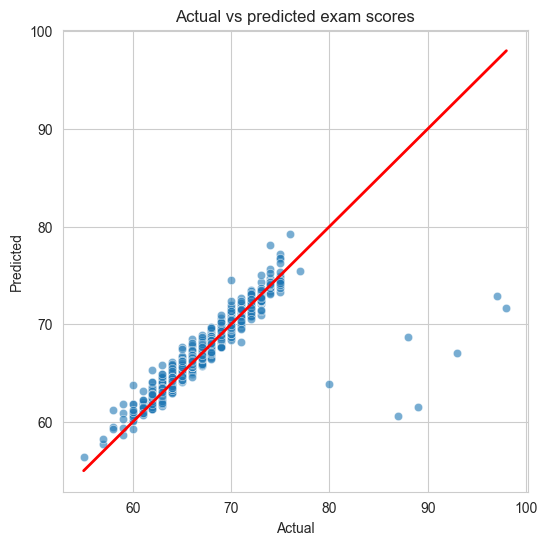

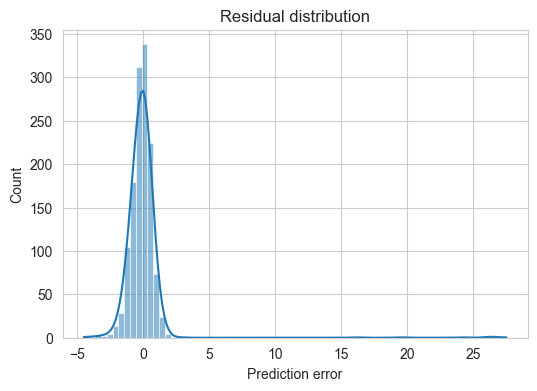

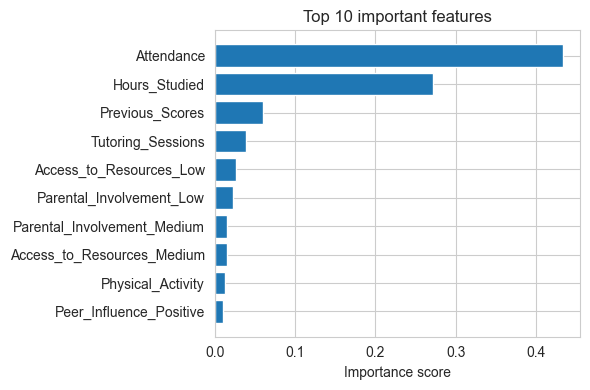

In [ ]:
# Create predictions from the best performing model
y_pred_best = y_pred_gb

# Plot 1: actual vs predicted
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred_best, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red", lw=2)
plt.title("Actual vs predicted exam scores")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

# Plot 2: residual distribution
residuals = y_test - y_pred_best
plt.figure(figsize=(6,4))
sns.histplot(residuals, kde=True)
plt.title("Residual distribution")
plt.xlabel("Prediction error")
plt.show()

# Plot 3: feature importance
importances = gb_model.feature_importances_
indices = np.argsort(importances)[-10:]  # top 10 important features

plt.figure(figsize=(6,4))
plt.barh(range(len(indices)), importances[indices], align="center")
plt.yticks(range(len(indices)), np.array(X_encoded.columns)[indices])
plt.title("Top 10 important features")
plt.xlabel("Importance score")
plt.tight_layout()
plt.show()

## 6 Final model comparison and conclusions

### 6.1 Final comparison summary

To conclude, I compared all models, including tuned and nonlinear variants to show their test performance. I'll print the resulting summary below to reflect the final optimized results after tuning and model refinement.

In [57]:
model_results = pd.DataFrame({
    "Model": ["Linear regression", "Decision tree", "Random forest",
              "Gradient boosting", "Polynomial regression", "Tuned random forest", "SVR"],
    "RMSE": [1.80, 3.77, 2.23, 1.90, 1.89, 2.18, 1.84],
    "r2": [0.77, 0.00, 0.65, 0.74, 0.75, 0.67, 0.76],
    "MAE": [0.45, 1.89, 1.18, 0.69, 0.64, 1.14, 0.51]
}).sort_values("r2", ascending=False).reset_index(drop=True)

model_results

,Model,RMSE,r2,MAE
0,Linear regression,1.80,0.77,0.45
1,SVR,1.84,0.76,0.51
2,Polynomial regression,1.89,0.75,0.64
3,Gradient boosting,1.90,0.74,0.69
4,Tuned random forest,2.18,0.67,1.14
5,Random forest,2.23,0.65,1.18
6,Decision tree,3.77,0.00,1.89


### 6.2 Conclusion

Linear regression turned out to be the best performing model overall. It achieved the highest r2 and the lowest prediction error, showing that student exam performance in this dataset follows mostly linear and additive patterns. Hours studied, attendance, and previous scores explained most of the variance in results.

Polynomial regression and SVR came close but did not add much predictive power. This suggests that introducing nonlinear terms or using kernel based methods didn't uncover additional structure in the data. Gradient boosting performed similarly but not better, which supports the idea that simple models can often generalize just as well when the relationships are stable and smooth.

Decision tree and random forest models performed notably worse. This confirms that the dataset does not benefit from splits or complex feature interactions and that tree based methods can easily overfit small structured datasets like this one.

Overall, the findings align with intuition: consistent study habits and attendance drive performance, and prior achievement remains a strong predictor. The residuals were centered around zero with only a few very high performing outliers, likely influenced by unmeasured factors such as motivation.

### 6.3 Next steps

One interesting follow up research could be to measure not just performance but how much students actually remember and can apply what they learn when using new learning tools like ChatGPT in the context of genAI.

These tools can improve access to knowledge but also alter how students approach learning, time management, and problem solving. Measuring these effects would require new variables and a different dataset but could provide more current insight into what drives student success today.

Instead of focusing only on grades or exam scores, it would be more meaningful to track:
1) recall of key concepts after some time has passed  
2) the ability to apply these concepts to new problems or contexts

This would help separate short term support from real learning. E.g. if students who use AI tooling perform well right after but struggle on delayed recall or transfer tasks, that would suggest surface level understanding. On the other hand, more consistent performance over time would point to deeper learning.

Collecting this kind of data would require a new dataset, likely combining short quizzes, delayed tests, and small projects where students apply their knowledge in dept. It would make for an interesting next step building on the current work.

The exploratory dataset analyzed next begins to move in this direction by including behavioral and attitudinal responses about ChatGPT use, offering a first step toward linking AI assisted study habits to learning outcomes.

## 7. Exploratory extension: ChatGPT dataset

This section explores an additional dataset on how students use ChatGPT for learning. The goal is to examine whether attitudes toward AI assisted study could add behavioral predictors that explain academic success. The dataset contains more than 20,000 responses from higher education students across 109 countries.

In [32]:
# Load ChatGPT dataset
data_path_chatgpt = Path("../data/raw/final dataset.xlsx")

if not data_path_chatgpt.exists():
    raise FileNotFoundError(f"File not found: {data_path_chatgpt}")

df_chatgpt = pd.read_excel(data_path_chatgpt)

print("Dataset loaded successfully")
print(f"Shape: {df_chatgpt.shape[0]} rows × {df_chatgpt.shape[1]} columns")
df_chatgpt.head()

Dataset loaded successfully
Shape: 23218 rows × 174 columns


,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,Q40g,Q40h,Q40i,Q40j,Q40k,Q40l,Q40m,Q40n,Q40o,source
0,Afghanistan,2.0,27.0,Afghanistan,القدس المفتوحة,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AR
1,Afghanistan,4.0,100.0,Afghanistan,456,2.0,2.0,3.0,2.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EN
2,Afghanistan,1.0,21.0,Albania,منيا,1.0,1.0,1.0,1.0,1.0,...,3.0,2.0,3.0,4.0,3.0,2.0,2.0,1.0,1.0,EN
3,Afghanistan,1.0,18.0,Ecuador,"Universidad Indoamerica., Facultad Arquitectur...",2.0,1.0,1.0,1.0,4.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,ES
4,Afghanistan,2.0,26.0,Spain,De vigo universidad,1.0,2.0,2.0,1.0,2.0,...,4.0,3.0,4.0,3.0,3.0,3.0,4.0,3.0,4.0,ES


### 7.2 Data cleaning and preparation

Before exploring relationships in the ChatGPT dataset, I’ll again clean and simplify it a bit. This includes removing columns that contain no data or constant values, handling missing entries, and encoding categorical responses numerically where needed. The goal is to create a compact, analysis-ready version that reflects how students use ChatGPT and how these behaviors could later relate to learning outcomes.

Note: The dataset appears to represent self reported survey responses collected online from 109 countries. While it provides valuable insight into global attitudes toward AI-assisted learning, it is not a controlled academic sample. Therefore, results derived from this data should be interpreted as exploratory rather than conclusive.

In [ ]:
# Basic data cleaning
df_chatgpt_clean = df_chatgpt.copy()

# 1. Drop columns with missing values
threshold = 0.5
df_chatgpt_clean = df_chatgpt_clean.loc[:, df_chatgpt_clean.isnull().mean() < threshold]

# 2. Drop rows where all % columns are missing
df_chatgpt_clean.dropna(how="all", inplace=True)

# 3. Fill remaining missing values
for col in df_chatgpt_clean.columns:
    if df_chatgpt_clean[col].dtype == "object":
        df_chatgpt_clean[col].fillna(df_chatgpt_clean[col].mode()[0], inplace=True)
    else:
        df_chatgpt_clean[col].fillna(df_chatgpt_clean[col].median(), inplace=True)

# 4. Encode categorical variables numerically
categorical_cols = df_chatgpt_clean.select_dtypes(include="object").columns
df_chatgpt_clean[categorical_cols] = df_chatgpt_clean[categorical_cols].apply(lambda x: x.astype("category").cat.codes)

# 5. Verify cleaning
print(f"After cleanup: {df_chatgpt_clean.shape[0]} rows × {df_chatgpt_clean.shape[1]} columns")
print("Remaining missing values:", df_chatgpt_clean.isnull().sum().sum())


After cleanup: 23218 rows × 174 columns
Remaining missing values: 0


### 7.3 Visualization and exploration

Now that the ChatGPT dataset is cleaned, I’ll visualize a few representative patterns. The goal is to understand how students across different countries perceive ChatGPT’s usefulness and how these attitudes vary by question.

I’ll start with basic distributions of key survey items, inspect correlations between them, and then look at which countries report the highest perceived usefulness.

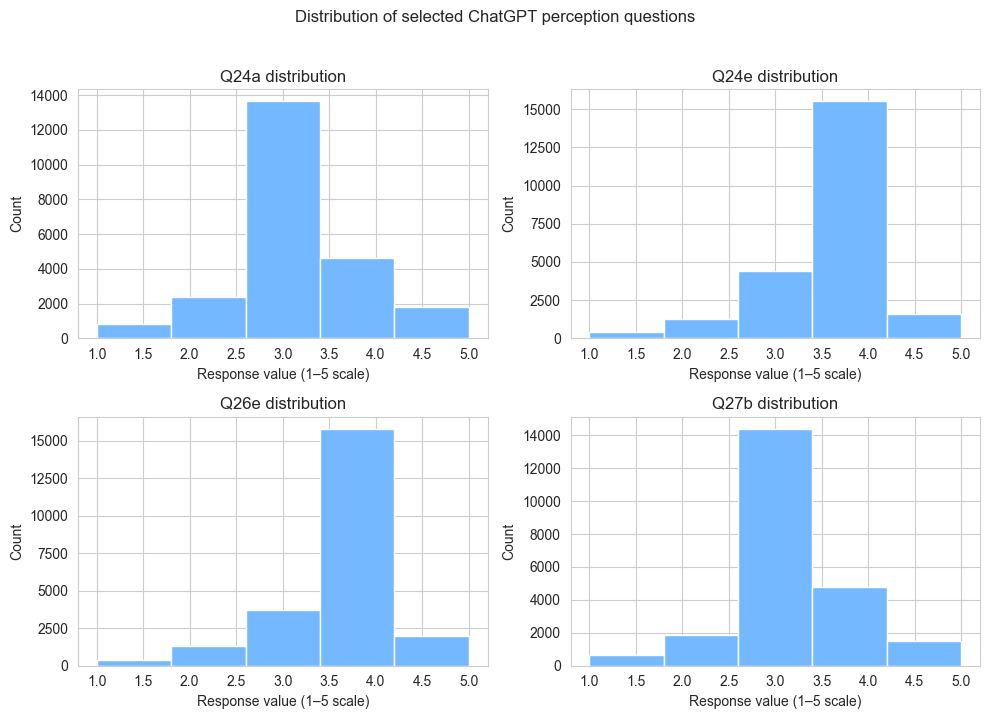

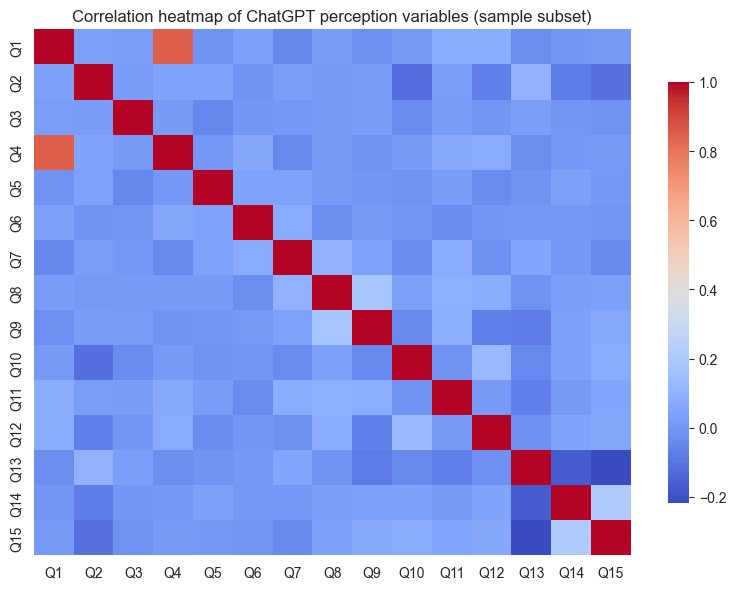

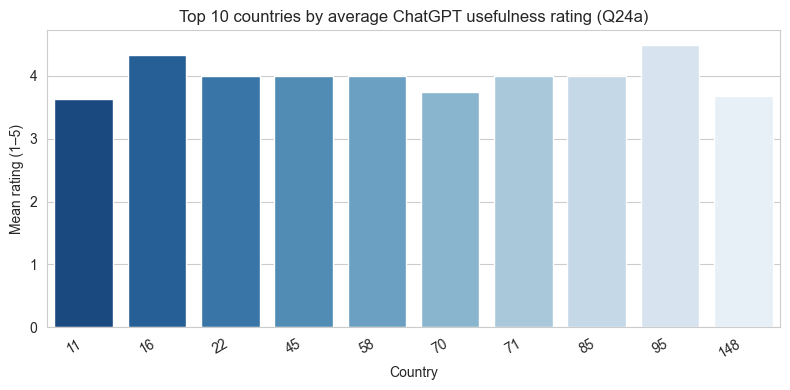

In [ ]:
# 1. Define representative perception variables 
selected_cols = ["Q24a", "Q24e", "Q26e", "Q27b"]

# 2. Plot distributions for the selected questions
fig, axes = plt.subplots(2, 2, figsize=(10, 7))
for ax, col in zip(axes.flatten(), selected_cols):
    df_chatgpt_clean[col].plot(kind="hist", bins=5, ax=ax, color="#74b9ff", edgecolor="white")
    ax.set_title(f"{col} distribution")
    ax.set_xlabel("Response value (1–5 scale)")
    ax.set_ylabel("Count")
plt.suptitle("Distribution of selected ChatGPT perception questions", fontsize=12, y=1.02)
plt.tight_layout()
plt.show()

# 3. Correlation heatmap for a subset of numeric variables
corr = df_chatgpt_clean.select_dtypes(include="number").corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr.iloc[:15, :15], cmap="coolwarm", cbar_kws={'shrink': 0.8})
plt.title("Correlation heatmap of ChatGPT perception variables (sample subset)", fontsize=12)
plt.tight_layout()
plt.show()

# 4. Top 10 countries by average perceived usefulness
country_means = (
    df_chatgpt_clean.groupby("Q1")[["Q24a", "Q24e", "Q26e", "Q27b"]]
    .mean()
    .sort_values(by="Q24a", ascending=False)
    .head(10)
)

plt.figure(figsize=(8, 4))
sns.barplot(
    data=country_means.reset_index(),
    x="Q1", y="Q24a",
    palette="Blues_r"
)
plt.title("Top 10 countries by average ChatGPT usefulness rating (Q24a)", fontsize=12)
plt.ylabel("Mean rating (1–5)")
plt.xlabel("Country")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

The distributions show that most students report agreement (moderate to high) with statements about ChatGPT’s usefulness and efficiency (typically 3–4 on a 5-point scale).

The correlation heatmap reveals moderate positive relationships among satisfaction, perceived usefulness, and efficiency items, suggesting they describe a coherent underlying perception construct.

The top-country chart highlights regional variation in adoption and sentiment: some countries consistently rate ChatGPT as more useful, while others remain neutral.  

## 8. Extending traditional predictors with behavioral insights

The supervised learning results confirmed that traditional features such as hours studied, attendance, and prior achievement remain the most reliable predictors of student exam performance. However, these variables describe what students do, not how they learn, and the latter may be changing rapidly.

A brief exploratory analysis of the ChatGPT dataset suggests that behavioral indicators of modern learning could complement these traditional predictors. Students who reported frequent or confident use of AI tooling also tended to express higher self assessed learning efficiency and problem solving confidence. While these variables were not included in the predictive model, they appear to capture similar underlying traits such as engagement, persistence, and openness to new learning methods.

Together, the two analyses suggest that future models of student success should expand beyond study time and attendance to include behavioral signals of learning adoption that could help educators identify not only who studies the most, but also who adapts fastest to new learning methods.